# Predicting cardiovascular disease in patients
#### Jeremy Jung (jj523) and Andrew Osorio (ao296)

# Problem and Hypothesis

### Problem

Cardiovascular diseases (CVDs) are the number one cause of death around the globe. Annually, more people suffer from CVDs than from any other disease. Although some CVDs are hereditary, most CVDs are not an inevitable part of life and could be prevented by avoiding major daily behaviors that put people in risk, including: substance abuse, obesity, and the lack of physical activity. Most premature deaths (under age of 70) related to CVDs are in low and middle income countries and have a lack of access to the most advanced medical attention. Although we are not doctors, we believe that everyone is entitled to understanding what it takes to live a healthier life. 

https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)

We hope that from the datasets we have collected, we can create a model to help people better understand whether or not they are at risk of cardiovascular disease. Furthermore, we hope to answer the question: What major factors contribute to cardiovascular disease?

### Hypothesis

After looking at the dataset, we predict that the most important feature in determining if a patient is at risk of cardiovascular disease are cholesterol and blood pressure levels. We hope to create a model that accurately predicts if a person has cardiovascular disease from the features in the data. Using classification models including but not limited to logistic regression, the k-nearest neighbor algorithm, and random forests, we believe that we can successfully model if patients are at risk of cardiovascular diseases.

### Data

All data was sourced from https://www.kaggle.com/sulianova/cardiovascular-disease-dataset.

# Data processing

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

cardio = pd.read_csv("cardio_train.csv", sep=";")

In [203]:
cardio.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


We calculate __BMI__, which is crucial to predicting whether a patient has cardiovascular disease. In order to calculate BMI, we use a formula which utilizes values from the dataset height and weight to better understand a patient’s obesity levels. We store BMI as a new feature to our data.

In [204]:
# Calculate BMI = weight (kg) / (height (m) ^ 2)
cardio["bmi"] = cardio["weight"] / ((cardio["height"] / 100) ** 2)

Using our BMI values, we create another feature called __obesity__, which has values from 0-3 based on how obese a person is. The thresholds we chose were taken from https://www.nhlbi.nih.gov/health/educational/lose_wt/BMI/bmicalc.htm.

In [205]:
# Calculate obesity
cardio["obesity"] = 0
cardio.loc[cardio["bmi"] < 18.5, "obesity"] = 0
cardio.loc[(cardio["bmi"] >= 18.5) & (cardio["bmi"] <= 24.9), "obesity"] = 1
cardio.loc[(cardio["bmi"] >= 25) & (cardio["bmi"] <= 29.9), "obesity"] = 2
cardio.loc[cardio["bmi"] > 30, "obesity"] = 3

The blood pressure columns seem to have some errors, as demonstrated below. The highest blood pressure ever recorded is 370/360, and even then, that person's mean blood pressure is 198/175 (source: https://www.ncbi.nlm.nih.gov/pubmed/7741618). As a result, it would make no sense that there are columns with a blood pressure like 906 for systolic blood pressure.

In [206]:
print("Readings above 200:", len(cardio[cardio['ap_hi'] > 200]))
cardio[cardio['ap_hi'] > 200].head(2)

Readings above 200: 100


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,obesity
1328,1863,21063,2,174,106.0,220,120,3,3,0,0,1,0,35.01123,3
1876,2654,15116,1,160,60.0,902,60,1,1,0,0,1,0,23.43750,1


In [207]:
print("Readings above 200:", len(cardio[cardio['ap_lo'] > 200]))
cardio[cardio['ap_lo'] > 200].head(2)

Readings above 200: 953


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,obesity
228,314,17489,2,183,98.0,160,1100,1,2,1,0,1,1,29.263340,2
241,334,21932,2,157,60.0,160,1000,2,1,0,0,0,1,24.341758,1


In [208]:
print("Readings below 40:", len(cardio[cardio['ap_hi'] < 40]))
cardio[cardio['ap_hi'] < 40].head(2)

Readings below 40: 188


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,obesity
567,815,21281,1,168,78.0,14,90,2,1,0,0,1,1,27.636054,2
927,1294,21867,2,175,70.0,14,90,3,1,0,0,1,1,22.857143,1


In [209]:
print("Readings below 40:", len(cardio[cardio['ap_lo'] < 40]))
cardio[cardio['ap_lo'] < 40].head(2)

Readings below 40: 59


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,obesity
418,594,16658,1,157,72.0,150,30,1,1,0,0,1,1,29.210110,2
2014,2845,22712,2,167,59.0,906,0,1,1,0,0,1,0,21.155294,1


As a result, we capped the systolic blood pressure and diastolic blood pressure readings at two standard deviations away from the mean from both sides.

In [123]:
# Bound rows two standard deviations above the mean
upper_bound_hi = cardio['ap_hi'].quantile(.95)
upper_bound_lo = cardio['ap_lo'].quantile(.95)
lower_bound_hi = cardio['ap_hi'].quantile(.05)
lower_bound_lo = cardio['ap_lo'].quantile(.05)


cardio['ap_hi'][(cardio['ap_hi'] > upper_bound_hi)] = upper_bound_hi
cardio['ap_lo'][(cardio['ap_lo'] > upper_bound_lo)] = upper_bound_lo
cardio['ap_hi'][(cardio['ap_hi'] < lower_bound_hi)] = lower_bound_hi
cardio['ap_lo'][(cardio['ap_lo'] < lower_bound_lo)] = lower_bound_lo

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Finally, we create a new feature called __blood pressure__, which is based on systolic and diastolic blood pressure readings. The feature has values from 0-4, which represents how normal your blood pressure is. 0 represents normal blood pressure, while 4 represents a crisis in blood pressure. We found the thresholds at https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings.

In [124]:
# Calculate blood pressure
cardio["blpr"] = 0
cardio.loc[(cardio["ap_hi"] >= 120) & (cardio["ap_hi"] < 130) & (cardio["ap_lo"] < 80), "blpr"] = 1
cardio.loc[(cardio["ap_hi"] >= 130) & (cardio["ap_hi"] < 140) & (cardio["ap_lo"] >= 80) & (cardio["ap_lo"] < 90), "blpr"] = 2
cardio.loc[(cardio["ap_hi"] >= 140) & (cardio["ap_hi"] <= 180) & (cardio["ap_lo"] >= 90) & (cardio["ap_lo"] <= 120), "blpr"] = 3
cardio.loc[(cardio["ap_hi"] > 180) & (cardio["ap_lo"] > 120), "blpr"] = 4

# Visualization

Before we begin to model our predictions, we feel that it is important to create simple visualizations, just to understand how the data itself looks.

We create a bar graph to compare the frequency of cardiovascular disease for the three different cholesterol levels in the dataset: 1 = normal, 2 = above normal, and 3 = well-above normal. 

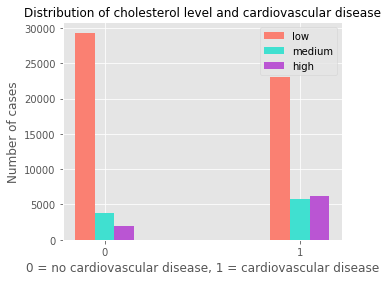

In [200]:
low_cl_no_cardio = (cardio['cholesterol'] == 1) & (cardio['cardio'] == 0)
low_cl_cardio = (cardio['cholesterol'] == 1) & (cardio['cardio'] == 1)

med_cl_no_cardio = (cardio['cholesterol'] == 2) & (cardio['cardio'] == 0)
med_cl_cardio = (cardio['cholesterol'] == 2) & (cardio['cardio'] == 1)

high_cl_no_cardio = (cardio['cholesterol'] == 3) & (cardio['cardio'] == 0)
high_cl_cardio = (cardio['cholesterol'] == 3) & (cardio['cardio'] == 1)

low_cl = [len(cardio[low_cl_no_cardio]), len(cardio[low_cl_cardio])]
med_cl = [len(cardio[med_cl_no_cardio]), len(cardio[med_cl_cardio])]
high_cl = [len(cardio[high_cl_no_cardio]), len(cardio[high_cl_cardio])]

width = 0.1

plt.style.use(['ggplot'])

p1 = np.arange(2)
p2 = [x+width for x in p1]
p3 = [x+width for x in p2]

plt.figure(figsize=(5, 4))

plt.bar(p1, low_cl, color='salmon', width=width, label='low')
plt.bar(p2, med_cl, color='turquoise', width=width, label='medium')
plt.bar(p3, high_cl, color='mediumorchid', width=width, label='high')

plt.xticks([width, 1+width], [0, 1])
plt.legend()

plt.xlabel("0 = no cardiovascular disease, 1 = cardiovascular disease")
plt.ylabel("Number of cases")
plt.title("Distribution of cholesterol level and cardiovascular disease", fontdict={'fontsize': 12})

plt.show()

Clearly, the visualization here gives evidence for our hypothesis. For people with normal cholesterol, there were more people without cardiovascular disease than there were with cardiovascular disease. For people with cholesterol above normal levels, there were more people with cardiovascular disease than without.

We can also visualize the distribution of cardiovascular disease among people of different heights and weights, using a scatter plot.

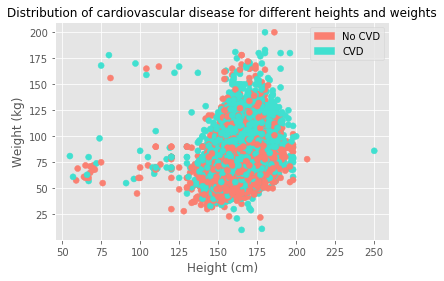

In [193]:
import matplotlib.patches as mpatches

colors=[]

for i in range(len(cardio)):
    if cardio.loc[i]["cardio"] == 1:
        colors.append("turquoise")
    else:
        colors.append("salmon")

plt.scatter(cardio["height"], cardio["weight"], c=colors,cmap='Pastel2')

plt.style.use(['ggplot'])

plt.xlabel("Height (cm)")
plt.ylabel("Weight (kg)")

salmon = mpatches.Patch(color='salmon', label='No CVD')
turquoise = mpatches.Patch(color='turquoise', label='CVD')

plt.legend(handles=[salmon, turquoise])

plt.title("Distribution of cardiovascular disease for different heights and weights", {"fontsize": 12})

plt.show()

We can see that in general, people with higher weights for a given height appear to have more cases of cardiovascular disease.

# Training models

We will train several machine learning models on the dataset, including:

- Decision Tree Classifier
- Logistic Regression
- KNN
- Perceptron
- Linear SVC
- Random Forest

We will let each model train on the same training set (important for comparison), and then we will compare the results to see which algorithms seem to be the best to create an effective model.

In [153]:
X = cardio.drop(columns=['id', 'cardio'])
Y = cardio['cardio']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 40)

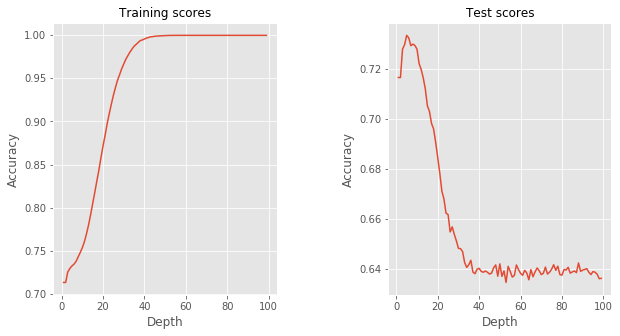

In [154]:
from sklearn.tree import DecisionTreeClassifier
dt_score = 0
train_score = 0
best_depth = 0
train_scores = []
test_scores = []
depths = list(np.arange(1, 100))
for k in depths:
    model = DecisionTreeClassifier(max_depth=k)
    model.fit(X_train, Y_train)
    pred_train = model.predict(X_train)
    accuracy_train = accuracy_score(Y_train, pred_train)
    train_scores.append(accuracy_train)
    pred_test = model.predict(X_test)
    accuracy_test = accuracy_score(Y_test, pred_test)
    test_scores.append(accuracy_test)
    if dt_score < accuracy_test:
        dt_score = accuracy_test
        train_score = accuracy_train
        best_depth = k

plt.style.use(['ggplot'])

plt.subplots(figsize=(10,5))
plt.subplots_adjust(wspace=0.5)

plt.subplot(121)
plt.plot(depths, train_scores)
plt.title("Training scores", fontdict={'fontsize': 12})
plt.xlabel("Depth")
plt.ylabel("Accuracy")

plt.subplot(122)
plt.plot(depths, test_scores)
plt.title("Test scores", fontdict={'fontsize': 12})
plt.xlabel("Depth")
plt.ylabel("Accuracy")

plt.show()

In [156]:
print("Train Accuracy: ", train_score)
print("Test Accuracy: ", dt_score)
print("Best depth: ", best_depth)

Train Accuracy:  0.7323035714285714
Test Accuracy:  0.7334285714285714
Best depth:  5


In [157]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', multi_class='auto')
model.fit(X_train, Y_train)
lr_train = model.score(X_train, Y_train)
lr_score = model.score(X_test, Y_test)
print("Train Accuracy: ", lr_train)
print("Test Accuracy: ", lr_score)

Train Accuracy:  0.7254464285714286
Test Accuracy:  0.7252142857142857


In [158]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train, Y_train)
knn_train = model.score(X_train, Y_train)
knn_score = model.score(X_test, Y_test)
print("Train Accuracy: ", knn_train)
print("Test Accuracy: ", knn_score)

Train Accuracy:  0.7780714285714285
Test Accuracy:  0.684


In [159]:
from sklearn.linear_model import Perceptron
model = Perceptron()
model.fit(X_train, Y_train)
ptron_train = model.score(X_train, Y_train)
ptron_score = model.score(X_test, Y_test)
print("Train Accuracy: ", ptron_train)
print("Test Accuracy: ", ptron_score)

Train Accuracy:  0.5738392857142857
Test Accuracy:  0.5661428571428572


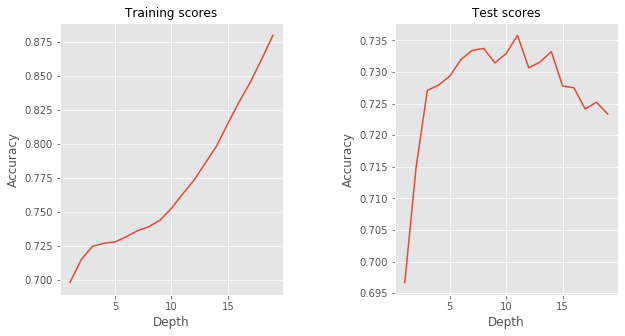

In [160]:
from sklearn.ensemble import RandomForestClassifier
rf_score = 0
train_score = 0
best_depth = 0
train_scores = []
test_scores = []
depths = list(np.arange(1, 20))
for k in depths:
    model = RandomForestClassifier(max_depth=k, n_estimators=20)
    model.fit(X_train, Y_train)
    pred_train = model.predict(X_train)
    accuracy_train = accuracy_score(Y_train, pred_train)
    train_scores.append(accuracy_train)
    pred_test = model.predict(X_test)
    accuracy_test = accuracy_score(Y_test, pred_test)
    test_scores.append(accuracy_test)
    if rf_score < accuracy_test:
        rf_score = accuracy_test
        train_score = accuracy_train
        best_depth = k

plt.style.use(['ggplot'])

plt.subplots(figsize=(10,5))
plt.subplots_adjust(wspace=0.5)

plt.subplot(121)
plt.plot(depths, train_scores)
plt.title("Training scores", fontdict={'fontsize': 12})
plt.xlabel("Depth")
plt.ylabel("Accuracy")

plt.subplot(122)
plt.plot(depths, test_scores)
plt.title("Test scores", fontdict={'fontsize': 12})
plt.xlabel("Depth")
plt.ylabel("Accuracy")

plt.show()

In [161]:
print("Train Accuracy: ", train_score)
print("Test Accuracy: ", rf_score)
print("Best depth: ", best_depth)

Train Accuracy:  0.7631964285714286
Test Accuracy:  0.7357857142857143
Best depth:  11


Now that we have trained and scored all of our models, we can compare the accuracy across the board for the models we picked.

In [162]:
model_data = {'Model': ['Decision Tree', 'Logistic Regression', 'KNN', 'Perceptron', 'Random Forest'],
             'Score': [dt_score, lr_score, knn_score, ptron_score, rf_score]}
model_results = pd.DataFrame(model_data)
model_results.sort_values(by=['Score'], ascending=False).reset_index().drop(columns=['index'])

,Model,Score
0,Random Forest,0.735786
1,Decision Tree,0.733429
2,Logistic Regression,0.725214
3,KNN,0.684000
4,Perceptron,0.566143


Looking at the scores, it appears that a random forest classifier is the best choice, in terms of accuracy. We perform a cross validation check to confirm that our accuracy score is valid.

In [179]:
from sklearn.model_selection import cross_val_score
model = RandomForestClassifier(max_depth=11, n_estimators=20)
scores = cross_val_score(model, X_train, Y_train, cv=10, scoring="accuracy")
print("Scores: ", scores)
print("Mean score: ", scores.mean())

Scores:  [0.73392857 0.73571429 0.72696429 0.74357143 0.725      0.73732143
 0.72821429 0.73571429 0.72982143 0.73303571]
Mean score:  0.7329285714285714


# Further optimization

We can also use the feature importances aspect of the random forest classifier to look at features that are not as important to the random forest classifier. These features that are of minimal importance to our model could potentially be dropped, as they could potentially contribute instead to creating noise in the data, which can lead to larger variance.

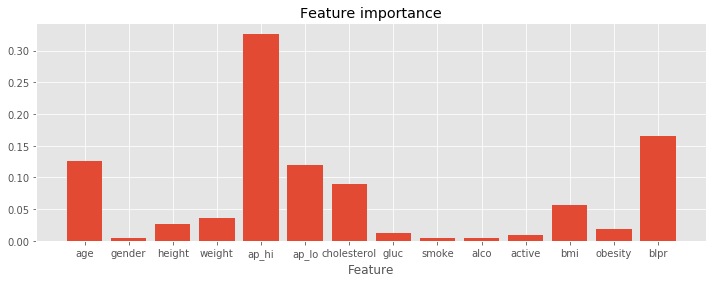

In [166]:
from sklearn.ensemble import RandomForestClassifier
X = cardio.drop(columns=['id', 'cardio'])
Y = cardio['cardio']
model = RandomForestClassifier(max_depth=11, n_estimators=20)
model.fit(X, Y)
feature_importances = model.feature_importances_

plt.style.use(['ggplot'])
plt.figure(figsize=(12, 4))
plt.bar(X.columns, feature_importances)
plt.title("Feature importance")
plt.xlabel("Feature")
plt.show()

Looking at the feature importances here, we can see that the feature rankings support our hypothesis. Systolic blood pressure was the most important factor for the random forest, and furthermore, the column we created for blood pressure came in second. Diastolic blood pressure and cholesterol were important factors as well. Interestingly, age seems to be an important factor, something we did not mention in our hypothesis.

From the feature importance ratings, we can also pick out a few features to drop. We see that gender, smoke, and alcohol all had low feature importances, giving us an indication that these features may just add noise and create variance in the data. 

We can try running a cross validation on the random forest again, after dropping these columns.

In [178]:
X = cardio.drop(columns=['id', 'cardio', 'smoke', 'alco', 'gender'])
Y = cardio['cardio']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 40)
model = RandomForestClassifier(max_depth=11, n_estimators=20)
scores = cross_val_score(model, X_train, Y_train, cv=10, scoring="accuracy")
print("Scores: ", scores)
print("Mean score: ", scores.mean())

Scores:  [0.73410714 0.73214286 0.73089286 0.74839286 0.72446429 0.73464286
 0.72625    0.73714286 0.73428571 0.73660714]
Mean score:  0.7338928571428571


Although the gain in accuracy for cross validation is not large by any means, the dropping of columns of minimal importance to the random forest could have contributed to lowering the variance, leading to more consistent results.

We can also try running a voting classifier using the three machine learning algorithms that we saw created the best models.

In [191]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
model1 = DecisionTreeClassifier(max_depth=5)
model2 = RandomForestClassifier(max_depth=11, n_estimators=20)
model3 = LogisticRegression(solver='liblinear', multi_class='auto')
models = [('dt', model1), ('rf', model2), ('lr', model3)]
ensemble = VotingClassifier(models)
scores = cross_val_score(ensemble, X_train, Y_train, cv=10, scoring="accuracy")
print("Scores: ", scores)
print("Mean score: ", scores.mean())

Scores:  [0.73303571 0.7375     0.73160714 0.74375    0.72464286 0.73517857
 0.72928571 0.73875    0.73214286 0.73928571]
Mean score:  0.7345178571428571


# Conclusion

Through working through the dataset, we learned that our hypothesis was supported by the data, but we also learned that age appears to be an important factor as well. 

Our visualizations and model training support our hypothesis that blood pressure levels and cholesterol are some of the most important factors in determining if a person has cardiovascular disease, and furthermore, we learned that age is also an important factor.

When it comes to the building of our model, we believe we were able to reasonably improve our data through feature engineering as well as optimization. Our best machine learning model was the random forest, which performed at an accuracy of approximately 73.3% in cross validation and 73.6% for just the train test split that we chose. Using a voting classifier combining the random forest with two other of our best performing machine learning models, we were also able to raise the accuracy to around 73.5% in cross validation. 

In the future, we hope to continue to improve on this experiment by finding new ways to engineer new features. We believe we could have improved our score further had we found a more clever way to engineer features. We also hope to improve by learning new machine learning models. Although we chose a small subset of classification models for our analysis, we realize that there are so many other algorithms that we can apply to this model, and we hope through further research we could potentially find one that works even better than the ones we have now. 